In [214]:
import pandas
import sqlalchemy
import matplotlib.pyplot as plt

In [215]:
engine = sqlalchemy.create_engine('sqlite:///solarthermal.db')

In [241]:
sql = "SELECT * FROM solarthermal WHERE timestamp > '2024-01-10 10:30'"
df = pandas.read_sql(sql, engine)
df['timestamp'] = pandas.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.rename(columns={'temp1': 't_ret', 'temp2': 't_flow'})
df['temp_diff'] = df['t_ret'] - df['t_flow']

Text(0, 0.5, 'Temp in degC')

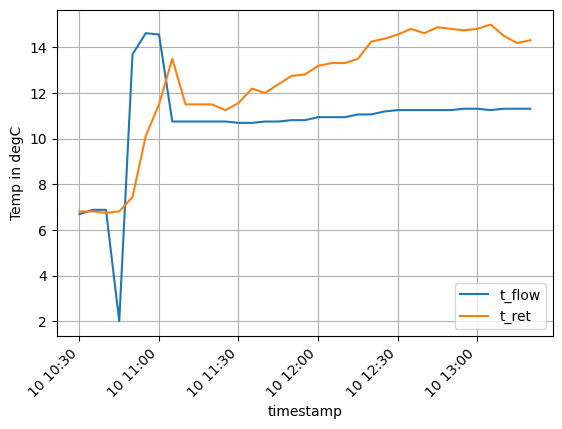

In [242]:
fig, ax = plt.subplots()

df.plot(ax=ax, y=['t_flow', 't_ret'], rot=45, grid=True)
ax.set_ylabel('Temp in degC')

Text(0, 0.5, 'Delta T in degC')

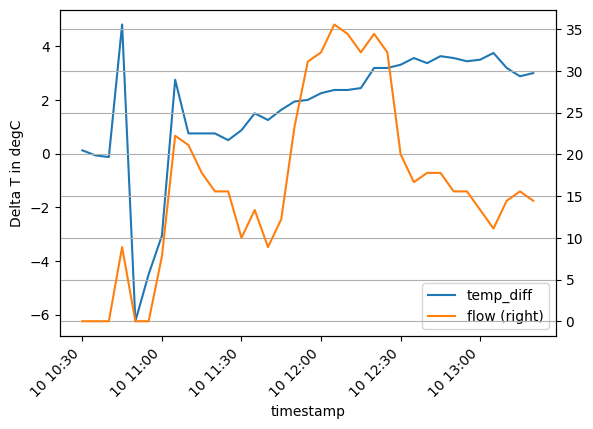

In [243]:
fig, ax = plt.subplots()

df.plot(ax=ax, y='temp_diff', rot=45)
df.plot(ax=ax, y='flow', secondary_y=True, rot=45, grid=True)
ax.set_ylabel('Delta T in degC')

<Axes: >

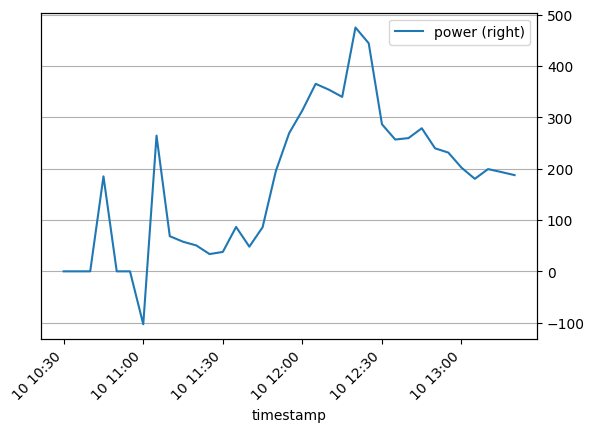

In [244]:
fig, ax = plt.subplots()

df.plot(ax=ax, y='power', secondary_y=True, rot=45, grid=True)

# How much energy

In [237]:
energy = df.resample('15T').mean()['power'].sum() / 4
energy

365.5804166666666

# How many kWh to raise one degree?
222 gal = 0.840361 cubic meter

In [238]:
m = 840 # kg
cp = 4.186 # kJ/kg/K
delta_T = 1
E_J = m * cp * delta_T
E_kWh = E_J/3600
E_kWh

0.9767333333333332

# How much should the temperature have risen?

In [239]:
energy/1000/ E_kWh

0.3742888710668214

In [240]:
df['t_flow']

timestamp
2024-01-10 10:30:02.527289     6.69
2024-01-10 10:35:02.605347     6.88
2024-01-10 10:40:02.685077     6.88
2024-01-10 10:45:02.684995     2.00
2024-01-10 10:50:02.742759    13.69
2024-01-10 10:55:02.724941    14.62
2024-01-10 11:00:02.782848    14.56
2024-01-10 11:05:02.800049    10.75
2024-01-10 11:10:02.751218    10.75
2024-01-10 11:15:03.804822    10.75
2024-01-10 11:20:02.395745    10.75
2024-01-10 11:25:02.442647    10.75
2024-01-10 11:30:02.476242    10.69
2024-01-10 11:35:02.497247    10.69
2024-01-10 11:40:02.282737    10.75
2024-01-10 11:45:02.030926    10.75
2024-01-10 11:50:02.864357    10.81
2024-01-10 11:55:02.685326    10.81
2024-01-10 12:00:02.449821    10.94
2024-01-10 12:05:02.285294    10.94
2024-01-10 12:10:02.099455    10.94
2024-01-10 12:15:02.829488    11.06
2024-01-10 12:20:02.806899    11.06
2024-01-10 12:25:02.564688    11.19
2024-01-10 12:30:02.316543    11.25
2024-01-10 12:35:02.079400    11.25
Name: t_flow, dtype: float64